In [ ]:
import h5py, math, numpy as np

In [ ]:
# read the hdf5 dataset
f = h5py.File("/content/drive/MyDrive/SEP28K.hdf5", 'r')

# create train, test, validation splits
trainX, trainY, testX, testY, validX, validY = f['trainX'], f['trainY'], f['testX'], f['testY'], f['validX'], f['validY']

print(trainX.shape)

(22537, 48000)


In [ ]:
# Calculate sample distribution
mean, var, std = 0, 0, 0
for sample in trainX:
  mean += sample.mean()
  var += sample.var() + sample.mean()**2

mean /= trainX.shape[0]
var = var/trainX.shape[0] - mean**2
std = math.sqrt(var)

print(mean, var, std)

-3.0667358666907646e-05 0.006991717701056645 0.08361649180070069


In [ ]:
!pip install pydub

In [ ]:
def clip(audio, step=500, clip_len=3000):
  # clip to 3 seconds
  clips = []
  start = 0
  while start + clip_len < int(len(audio)):
    clips.append(audio[start:start+clip_len])
    start += step
  return clips

In [ ]:
# Load test data
from IPython.display import Audio
from pydub import AudioSegment

SPEECH_FILE = '/content/drive/MyDrive/录音 (3).wav'
audio = Audio(SPEECH_FILE)
display(audio)

# clip
audio = AudioSegment.from_wav(SPEECH_FILE)
audio = audio.set_frame_rate(16000)
audio = audio.set_channels(1)
step, clip_len = 500, 3000
audio = clip(audio, step, clip_len)

for i in range(len(audio)):
  audio[i] = np.array(audio[i].get_array_of_samples())
audio = np.array(audio)
audio = audio.astype(np.float32)

print(audio.mean(), audio.std())
print(np.abs(audio).min(), np.abs(audio).max())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# align by mean & std
def align(audio, mean, std):
  # normalize
  audio = (audio - audio.mean()) / audio.std()
  # align with training data
  audio = audio * std + mean
  return audio

for i in range(audio.shape[0]):
  audio[i] = align(audio[i], mean, std)

In [ ]:
import scipy.io.wavfile as wav
def numpy_to_wav(numpy_array, sample_rate, output_file):

    # Normalize the numpy array to ensure it has a proper amplitude range
    max_amplitude = np.max(np.abs(numpy_array))
    if max_amplitude > 0:
        normalization_factor = (2**15 - 1) / max_amplitude
        numpy_array = (numpy_array * normalization_factor).astype(np.int16)

    # Write the numpy array to a WAV file
    wav.write(output_file, sample_rate, numpy_array)

    return output_file

# check clips
for i in range(audio.shape[0]):
  numpy_to_wav(audio[i], 16000, f'test{i}.wav')

In [ ]:
!git clone https://github.com/huazai6161/EC523-Final-Project
%cd EC523-Final-Project/
import torchaudio
import torch
import torch.nn as nn
from StutterNet import SEP28KDataset, StutterNet, sigmoid

Cloning into 'EC523-Final-Project'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 210 (delta 17), reused 0 (delta 0), pack-reused 175
Receiving objects: 100% (210/210), 4.97 MiB | 19.05 MiB/s, done.
Resolving deltas: 100% (111/111), done.
/content/EC523-Final-Project


In [ ]:
# get device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # get device
print(device)

cpu


In [ ]:
# prepare data and predict
# create required transforms
spec = torchaudio.transforms.MelSpectrogram(n_mels=80, sample_rate=16000,
                                              n_fft=512, f_max=8000, f_min=0,
                                              power=0.5, hop_length=152, win_length=480)
db = torchaudio.transforms.AmplitudeToDB()
transforms = torch.jit.script(nn.Sequential(spec, db))

# create datasets
ds = SEP28KDataset(audio, np.ones((audio.shape[0],12)), transform=transforms)
dataloader = torch.utils.data.DataLoader(ds, batch_size=audio.shape[0], shuffle=False, num_workers=2, pin_memory=True)

# ensemble learning
state = torch.load("/content/drive/MyDrive/StutterNet2.pth", map_location=device)
net1 = StutterNet(80, dropout=0.2, scale=2).to(device)
net1.load_state_dict(state['state_dict'])
net1.eval()

state = torch.load("/content/drive/MyDrive/StutterNet.pth", map_location=device)
net2 = StutterNet(80, dropout=0.2).to(device)
net2.load_state_dict(state['state_dict'])
net2.eval()

# prediction placeholders
preds = np.zeros((len(ds), 12))

for data in iter(dataloader):
  # get features and labels
  inputs, labels = data[0].to(device), data[1].detach().cpu().numpy()

  # get predictions
  preds = (net1(inputs).detach().cpu().numpy() + net2(inputs).detach().cpu().numpy()) / 2

/content/EC523-Final-Project/StutterNet/io.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(wav).clone().detach(), torch.tensor(labels).clone().detach()


In [ ]:
preds = sigmoid(preds)
preds

array([[2.42591079e-04, 9.70250621e-05, 2.54385261e-04, 7.89366476e-03,
        2.54564988e-03, 1.43361872e-03, 4.62803285e-07, 4.91843652e-03,
        1.56321985e-04, 2.55929335e-04, 1.89607832e-04, 9.99815047e-01],
       [2.63003516e-04, 1.00146863e-04, 2.76106031e-04, 9.64024290e-03,
        3.28336866e-03, 1.86865428e-03, 2.61076252e-07, 6.11727918e-03,
        8.32833248e-05, 1.93335538e-04, 1.75462264e-04, 9.99942303e-01],
       [2.10734099e-04, 7.88422476e-05, 2.16159533e-04, 9.27393977e-03,
        3.42712132e-03, 2.32182350e-03, 1.85555024e-07, 2.00501946e-03,
        6.30546419e-05, 1.39866475e-04, 7.60305993e-05, 9.99983311e-01],
       [2.00885566e-04, 8.31303478e-05, 2.04602678e-04, 1.03961919e-02,
        2.80808401e-03, 2.30423920e-03, 8.12244281e-08, 1.56692008e-03,
        1.13697897e-04, 3.24836350e-04, 5.58144129e-05, 9.99990463e-01],
       [2.78492051e-04, 1.24213519e-04, 2.98915314e-04, 1.03248442e-02,
        3.34316422e-03, 3.32125323e-03, 3.71824342e-07, 5.14

(66, 12)
['PoorAudioQuality' 'Unsure' 'DifficultToUnderstand' 'NaturalPause'
 'Music' 'NoSpeech' 'Prolongation' 'Block' 'SoundRep' 'WordRep'
 'Interjection' 'NoStutteredWords']


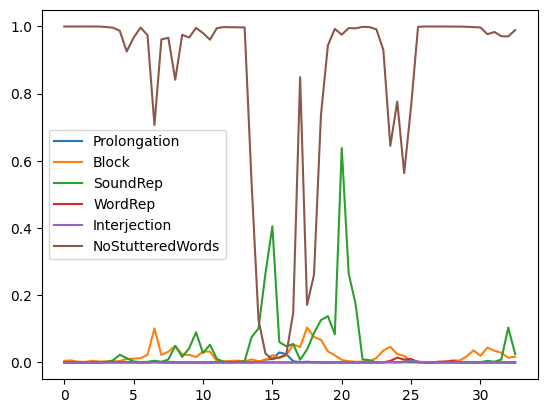

In [ ]:
# plot the prediction
import matplotlib.pyplot as plt
print(preds.shape)
names = np.loadtxt('classes.txt', dtype=str)
print(names)

for i in range(6,12):
  plt.plot(np.arange(preds.shape[0])*step/1000, preds[:,i], label=names[i])
plt.legend()
plt.show()

0.99999046 8.122443e-08
(66, 12)


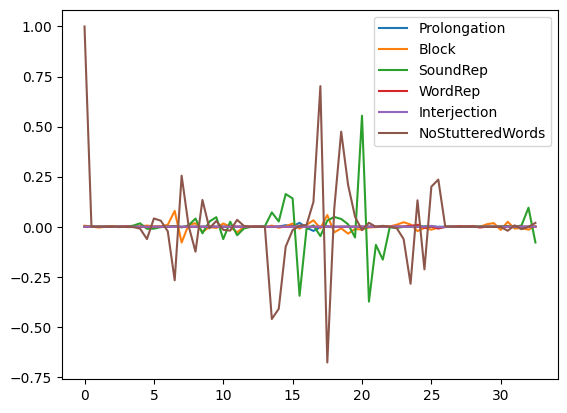

In [ ]:
# 差分
print(preds.max(), preds.min())
dpreds = np.zeros(preds.shape)
print(dpreds.shape)
dpreds[0] = preds[0]
for i in range(1, preds.shape[0]):
  dpreds[i] = preds[i] - preds[i-1]
for i in range(6,12):
  plt.plot(np.arange(preds.shape[0])*step/1000, dpreds[:,i], label=names[i])
plt.legend()
plt.show()

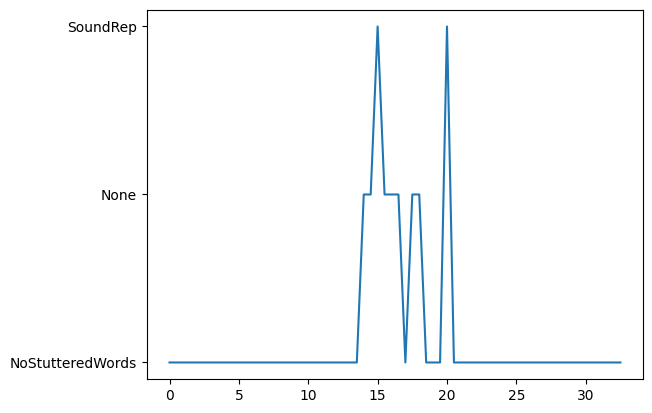

In [63]:
# ad-hoc
first_threshold = 0.3
second_threshold = 0.2
cur_stat = None
pred = []
for i in range(preds.shape[0]):
  ac = np.argmax(dpreds[i])
  pr = np.argmax(preds[i])
  if cur_stat != None and dpreds[i,cur_stat] < -second_threshold:
    cur_stat = None
  if dpreds[i,ac] > second_threshold:
    cur_stat = ac
  if cur_stat == None and preds[i,pr] > first_threshold:
    cur_stat = pr
  if cur_stat == None:
    pred.append('None')
  else:
    pred.append(names[cur_stat])

plt.plot(np.arange(preds.shape[0])*step/1000, pred)
plt.show()